Notebook de l'expérience
-----

### Librairies utilisées

In [1]:
import pandas as pd
import numpy as np
import gc

from pandas_profiling import ProfileReport

from transparentai.datasets import variable

In [2]:
gc.collect()

20

### Chargement des données

In [3]:
data = pd.read_csv('data/UCI_Credit_Card.csv', sep=',')

### Analyse rapide du jeu de données

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [5]:
data.shape

(30000, 25)

In [6]:
data.sample(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
12171,12172,370000.0,1,2,2,30,-1,-1,-1,-1,...,3661.0,4484.0,24233.0,2096.0,1263.0,3665.0,4488.0,24262.0,11175.0,1
14197,14198,350000.0,2,1,2,36,-1,-1,-1,-1,...,6531.0,4440.0,750.0,23537.0,5.0,10971.0,0.0,750.0,0.0,0
27399,27400,280000.0,1,2,1,45,-1,-1,-1,-1,...,1207.0,1207.0,1207.0,1207.0,1207.0,1207.0,1207.0,1207.0,1207.0,0


### Pandas profiling

In [7]:
profile = ProfileReport(data, title="UCI_Credit_Card")

In [8]:
profile.to_file("analyse_donnees_UCI_Credit_Card.html")

In [7]:
gc.collect()

20

Pour plus de détail aller sur le rapport de [Pandas profiling](analyse_donnees_credit_home_application.html)

### Analyse des données

In [8]:
target = 'default.payment.next.month'
gender_col = 'SEX'

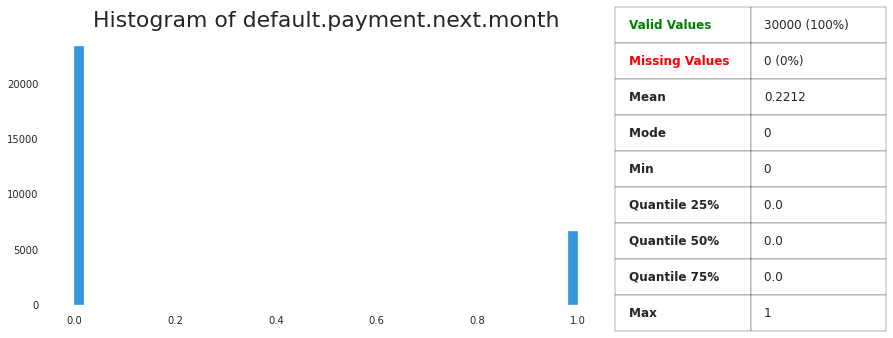

In [11]:
variable.plot_variable(data[target])

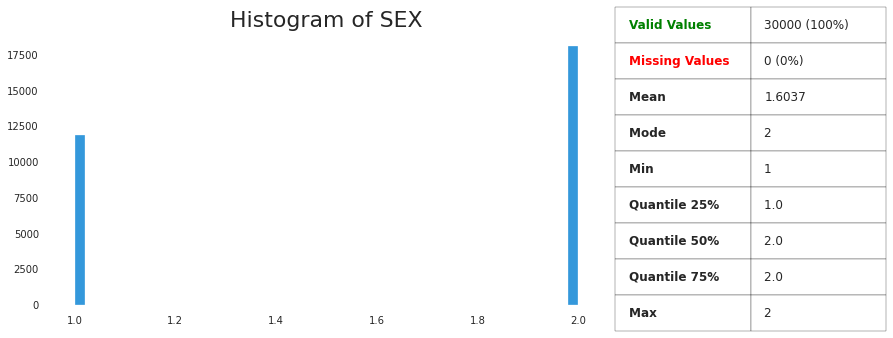

In [12]:
variable.plot_variable(data[gender_col])

Nous supprimons la colonnes `SK_ID_CURR` qui correspond à l'id des applications

In [13]:
data = data.drop(columns='ID')

#### Valeurs manquantes

In [14]:
def get_missing_val(df):
    df = df.copy()
    na_df = (df.isna().sum() / len(df)) * 100
    na_df = na_df[na_df > 0]
    na_df = na_df.sort_values(ascending=False)
    
    return na_df

na_df = get_missing_val(data)

In [15]:
na_df

Series([], dtype: float64)

In [16]:
def handle_missing_values(df):
    df = df.copy()
    
    num_vars = df.select_dtypes('number').columns
    oth_vars = [c for c in df.columns if c not in num_vars]
    
    df.loc[:,num_vars] = df[num_vars].fillna(df[num_vars].median())
    
    for var in oth_vars:
        df.loc[:,var] = df[var].fillna(df[var].value_counts().index[0])
        
    return df    

In [17]:
data = handle_missing_values(data)

In [18]:
na_df = get_missing_val(data)

In [19]:
na_df

Series([], dtype: float64)

In [20]:
gc.collect()

15791

### Analyse des variables catégoriques

In [21]:
categorical_variables = data.select_dtypes('object').columns

In [22]:
cnt_distinct_cat_var = data[categorical_variables].nunique()
cnt_distinct_cat_var

Series([], dtype: float64)

In [23]:
data.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

Parfait, il ne nous reste que des variables numériques !

### Corrélation avec le genre

In [24]:
corr = variable.compute_correlation(data)

In [25]:
corr[gender_col].sort_values().abs().sort_values(ascending=False)[:10]

SEX                           1.000000
AGE                           0.090874
PAY_2                         0.070771
PAY_3                         0.066096
PAY_4                         0.060173
PAY_0                         0.057643
PAY_5                         0.055064
PAY_6                         0.044008
default.payment.next.month    0.039961
BILL_AMT1                     0.033642
Name: SEX, dtype: float64

In [26]:
gc.collect()

40

Aucune variable ne sera donc à enlever excepté la variable `SEX` pour la morale de Charline.

#### Séparation train et validation

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
target = target
X, y = data.drop(columns=target), data[target]

# récupération des variables pour la morale de Charline
X_moral_c = X.drop(columns=gender_col)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
       X, y, test_size=0.2, random_state=42)

# récupération des variables pour la morale de Charline
X_train_moral_c = X_train.drop(columns=gender_col)
X_test_moral_c = X_test.drop(columns=gender_col)

In [30]:
X_train.shape, X_test.shape

((24000, 23), (6000, 23))

## Entraînement des modèles

In [34]:
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier

In [35]:
random_grid_rf = { 
    'n_estimators': [500, 600, 700, 800, 900, 1000],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 25, 40, 50, 60],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [36]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid_rf, 
                               scoring='f1', n_iter=5, cv=5, 
                               verbose=1, random_state=42, n_jobs=4)

In [37]:
gc.collect()

149

Entraînement de l'algorithme RandomForest

In [38]:
%%time
rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_
params_rf = best_rf.get_params()

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  6.8min finished


CPU times: user 1min 3s, sys: 190 ms, total: 1min 4s
Wall time: 7min 53s


In [39]:
%%time
rf_morale_c = RandomForestClassifier(**params_rf)
rf_morale_c.fit(X_train_moral_c, y_train)

CPU times: user 1min 6s, sys: 70.8 ms, total: 1min 6s
Wall time: 1min 6s


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [40]:
params_rf

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 700,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [41]:
gc.collect()

64

### Performance

In [42]:
from transparentai.models import classification

In [43]:
def proba_morale_b(X, y_pred):
    is_female = X[gender_col] == 2
    new_pred = y_pred.copy()
    
    tmp = new_pred[is_female][:,1] + 0.2
    tmp = np.array([min(p,1) for p in tmp])
    
    new_pred[is_female] = np.array([1-tmp, tmp]).T
    
    return new_pred

In [44]:
# Performance RandomForest
y_pred_morale_a_rf = best_rf.predict_proba(X_test)
y_pred_morale_b_rf = proba_morale_b(X_test, y_pred_morale_a_rf)
y_pred_morale_c_rf = rf_morale_c.predict_proba(X_test_moral_c)

In [45]:
metrics = ['accuracy','f1','precision','recall','TN','FP','FN','TP']

# RandomForest
perf_morale_a_rf = classification.compute_metrics(y_test, y_pred_morale_a_rf, metrics=metrics)
perf_morale_b_rf = classification.compute_metrics(y_test, y_pred_morale_b_rf, metrics=metrics)
perf_morale_c_rf = classification.compute_metrics(y_test, y_pred_morale_c_rf, metrics=metrics)

In [46]:
rf_perf = pd.DataFrame([perf_morale_a_rf, perf_morale_b_rf, perf_morale_c_rf], 
                       index=['Morale A RF', 'Morale B RF', 'Morale C RF'])

In [47]:
rf_perf

,accuracy,f1,precision,recall,TN,FP,FN,TP
Morale A RF,0.815667,0.459433,0.641201,0.357959,4424,263,843,470
Morale B RF,0.802167,0.504798,0.558118,0.460777,4208,479,708,605
Morale C RF,0.816167,0.460108,0.643836,0.357959,4427,260,843,470


### Controle des biais

In [48]:
from transparentai import fairness

In [49]:
best_model_a = best_rf
best_model_b = best_rf
best_model_c = rf_morale_c

In [50]:
y_pred_a = best_model_a.predict_proba(X)
y_pred_b = proba_morale_b(X, y_pred_a)
y_pred_c = best_model_c.predict_proba(X_moral_c)

In [51]:
privileged_group = {'SEX': ['Male']}

In [52]:
df = X.copy()
df['SEX'] = df['SEX'].replace({1:'Male',2:'Female'})

In [53]:
bias_a = fairness.model_bias(y, y_pred_a, df, privileged_group, pos_label=0)['SEX']
bias_b = fairness.model_bias(y, y_pred_b, df, privileged_group, pos_label=0)['SEX']
bias_c = fairness.model_bias(y, y_pred_c, df, privileged_group, pos_label=0)['SEX']

In [54]:
bias_score = pd.DataFrame([bias_a, bias_b, bias_c], index=['Morale A', 'Morale B', 'Morale C'])

In [55]:
bias_score

,statistical_parity_difference,disparate_impact,equal_opportunity_difference,average_odds_difference
Morale A,0.013007,1.014013,-0.000275,0.008098
Morale B,-0.052860,0.943053,-0.005292,-0.143362
Morale C,0.012581,1.013569,-0.000012,0.006474


MORALE A


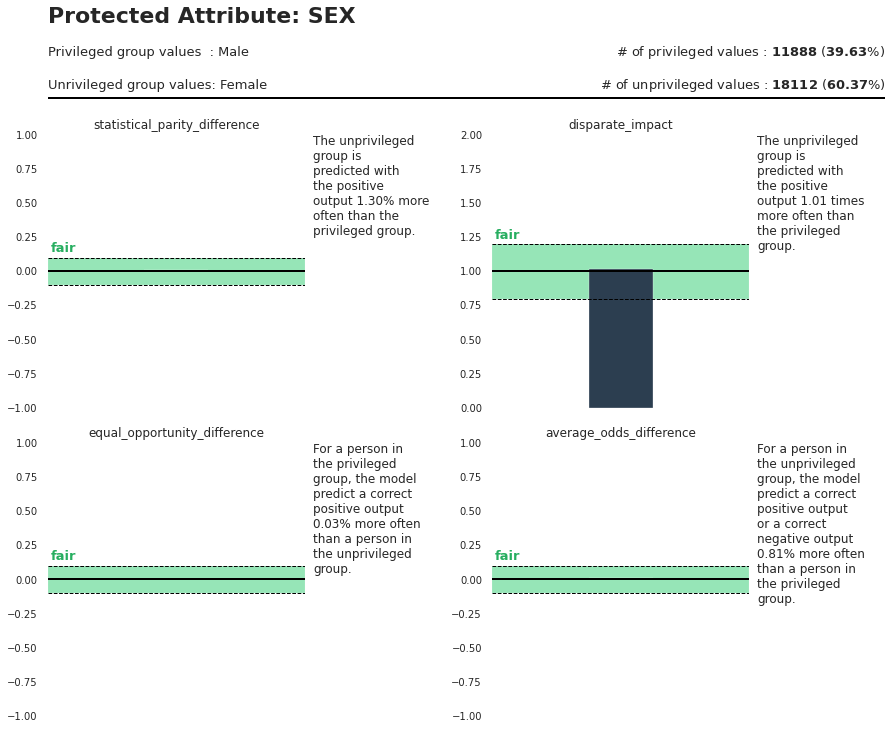

In [56]:
print('MORALE A')
fairness.plot_bias(y, y_pred_a, df, privileged_group, pos_label=0, with_text=True)

MORALE B


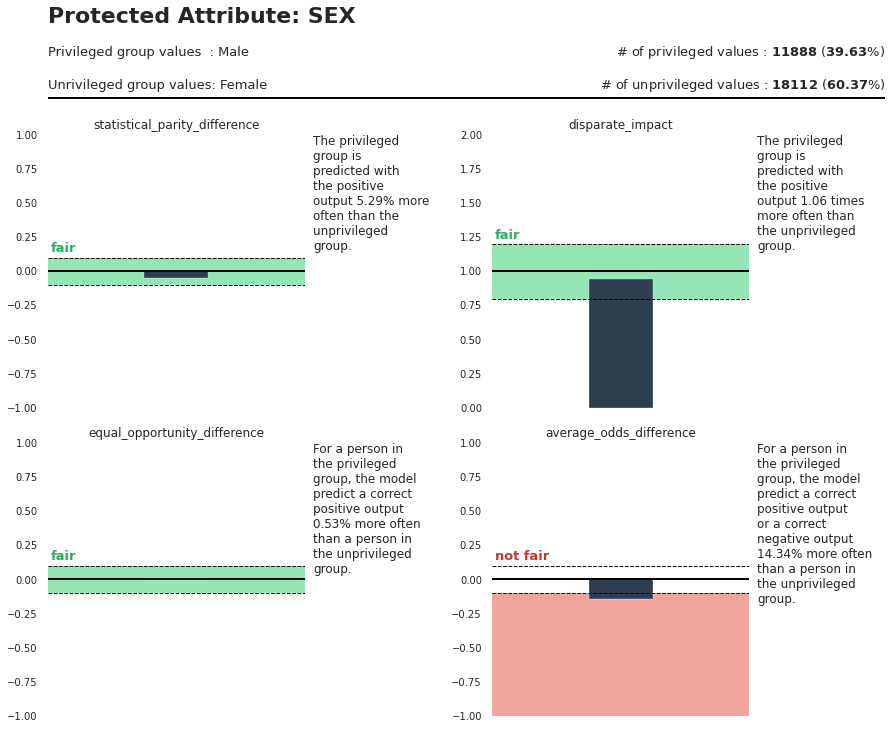

In [57]:
print('MORALE B')
fairness.plot_bias(y, y_pred_b, df, privileged_group, pos_label=0, with_text=True)

MORALE C


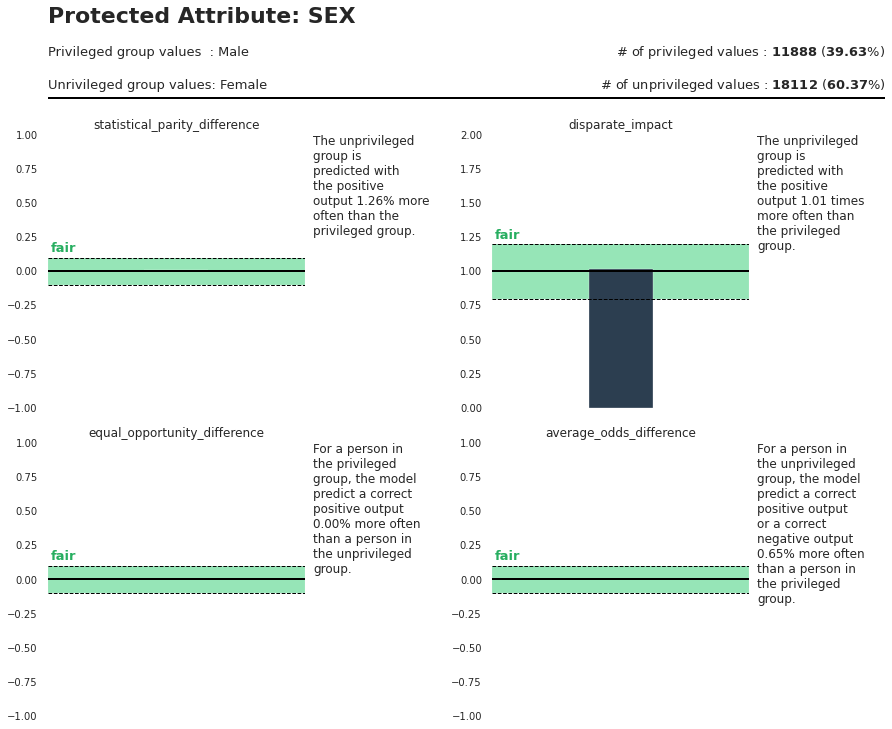

In [58]:
print('MORALE C')
fairness.plot_bias(y, y_pred_c, df, privileged_group, pos_label=0, with_text=True)

### Explicabilité des modèles

In [59]:
from transparentai.models import explainers

In [60]:
def proba_morale_b(X, y_pred):
    new_pred = y_pred.copy()
        
    if len(X.shape) == 1:
        is_female = X[1] == 2
    else:
        is_female = X[:,1] == 2
    
    tmp = new_pred[is_female][:,1] + 0.2
    tmp = np.array([min(p,1) for p in tmp])
    
    new_pred[is_female] = np.array([1-tmp, tmp]).T
    
    return new_pred

class Model_Morale_B():
    
    def __init__(self, model):
        self.model = model
        
    def predict_proba(self, X):
        if type(X) == list:
            X = np.array(X)
        if len(X.shape) == 1:
            X = X[np.newaxis,:]
            
        y_pred = self.model.predict_proba(X)
        return proba_morale_b(X, y_pred)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

model_b = Model_Morale_B(best_model_b)

In [61]:
explainer_a = explainers.ModelExplainer(best_model_a, X_train, model_type='tree')
explainer_b = explainers.ModelExplainer(model_b, X_train, model_type=None)
explainer_c = explainers.ModelExplainer(best_model_c, X_train_moral_c, model_type='tree')

In [62]:
explain_global_a = explainer_a.explain_global_influence(X_train, nsamples=100)
explain_global_b = explainer_b.explain_global_influence(X_train, nsamples=100)
explain_global_c = explainer_c.explain_global_influence(X_train_moral_c, nsamples=100)

 98%|===================| 197/200 [01:08<00:01]        

 99%|===================| 198/200 [01:05<00:00]        

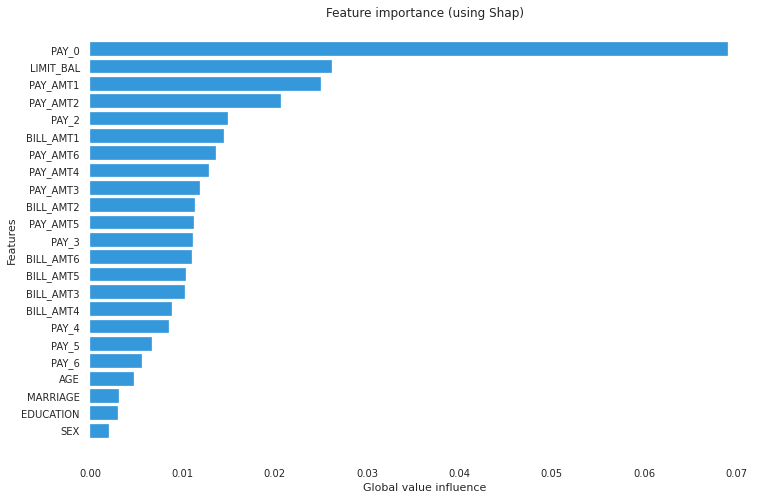

In [63]:
explainer_a.plot_global_explain()

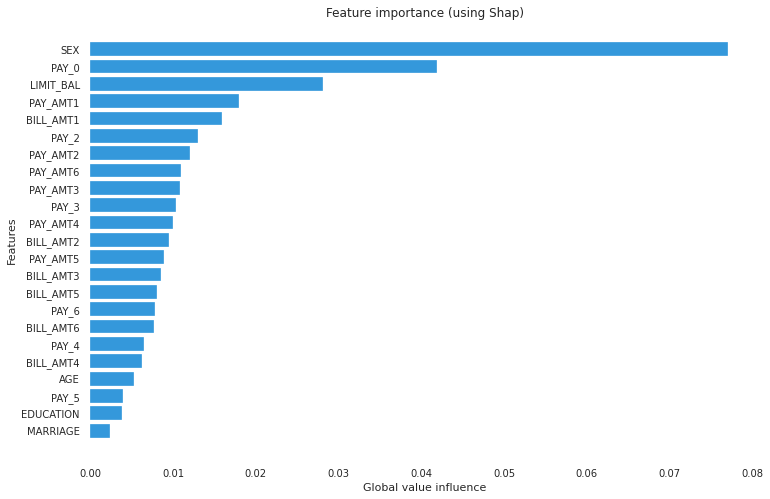

In [64]:
explainer_b.plot_global_explain()

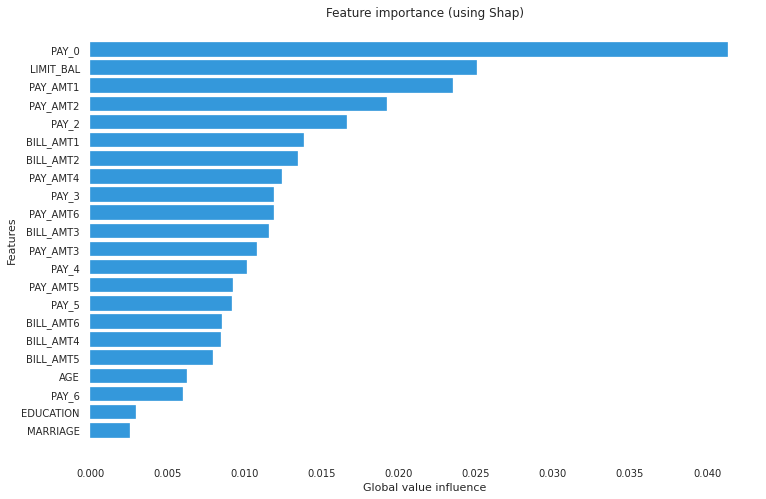

In [65]:
explainer_c.plot_global_explain()

#### Explication locale

Sélection de 10 hommes et de 10 femmes

In [66]:
np.random.seed(42)
male_sample = X[X['SEX'] == 1].sample(10)
female_sample = X[X['SEX'] == 2].sample(10)

In [67]:
from tqdm import tqdm

In [68]:
male_explain_a = list()
male_explain_b = list()
male_explain_c = list()
female_explain_a = list()
female_explain_b = list()
female_explain_c = list()

for idx, row in tqdm(male_sample.iterrows()):
    male_explain_a.append(explainer_a.explain_local_influence(row))
    male_explain_b.append(explainer_b.explain_local_influence(row))
    male_explain_c.append(explainer_c.explain_local_influence(row.drop('SEX')))
    
for idx, row in tqdm(female_sample.iterrows()):
    female_explain_a.append(explainer_a.explain_local_influence(row))
    female_explain_b.append(explainer_b.explain_local_influence(row))
    female_explain_c.append(explainer_c.explain_local_influence(row.drop('SEX')))

10it [01:28,  8.89s/it]
10it [01:27,  8.79s/it]


In [69]:
def format_explain_list(expl_list):
    out = list()
    for e in expl_list:
        tmp = {}
        for k,v in e.items():
            tmp[k.split(' = ')[0]] = v
        out.append(tmp)

    return pd.DataFrame(out)
    
male_explain_a = format_explain_list(male_explain_a)
male_explain_b = format_explain_list(male_explain_b)
male_explain_c = format_explain_list(male_explain_c)
female_explain_a = format_explain_list(female_explain_a)
female_explain_b = format_explain_list(female_explain_b)
female_explain_c = format_explain_list(female_explain_c)

In [70]:
import matplotlib.pyplot as plt

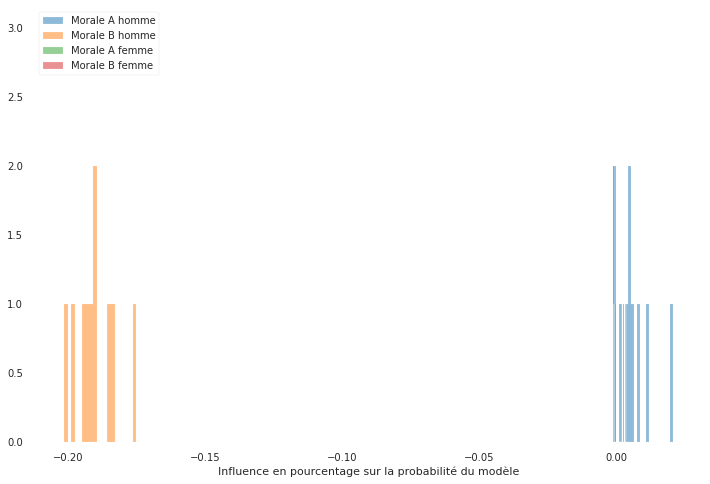

In [71]:
fig = plt.figure(figsize=(12,8))
kwargs = dict(histtype='stepfilled', alpha=0.5, bins=20)

plt.hist(male_explain_a['SEX'].values, label='Morale A homme', **kwargs)
plt.hist(male_explain_b['SEX'].values, label='Morale B homme', **kwargs)
plt.hist(female_explain_a['SEX'].values, label='Morale A femme', **kwargs)
plt.hist(female_explain_b['SEX'].values, label='Morale B femme', **kwargs)

plt.xlabel('Influence en pourcentage sur la probabilité du modèle')
plt.legend()
plt.show()

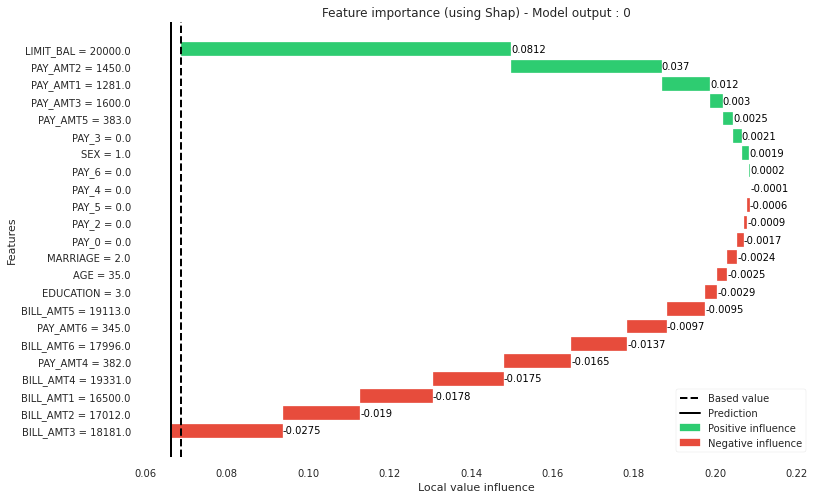

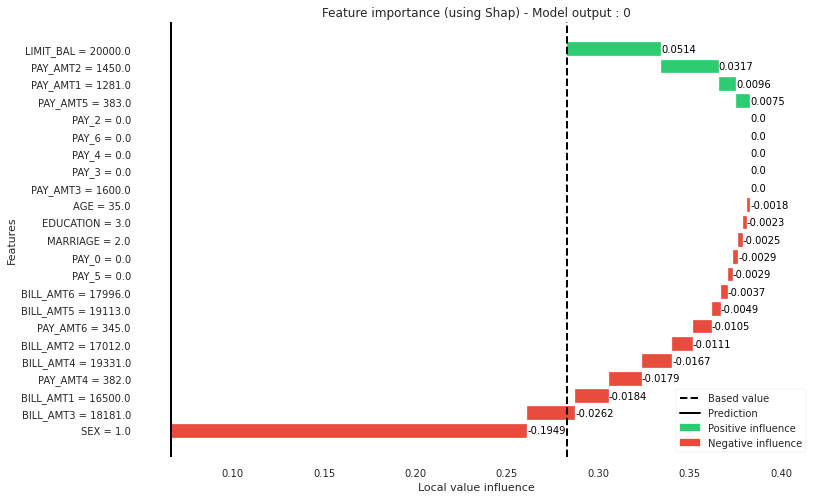

In [72]:
explainer_a.plot_local_explain(male_sample.iloc[0])
explainer_b.plot_local_explain(male_sample.iloc[0])

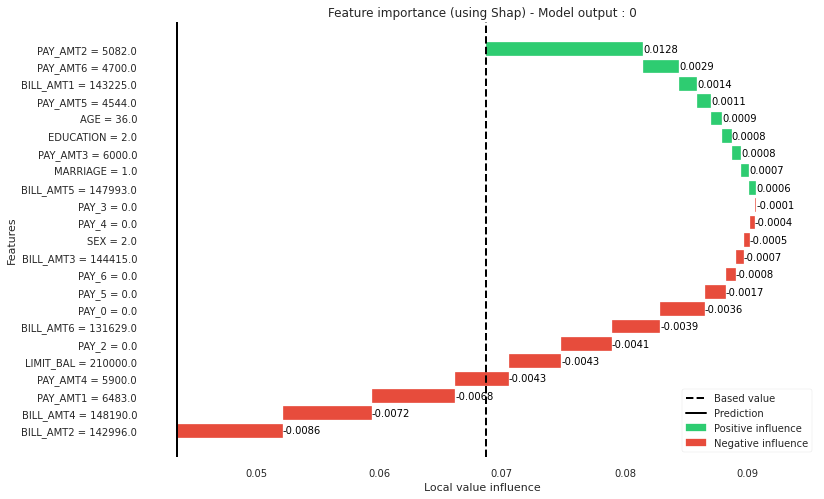

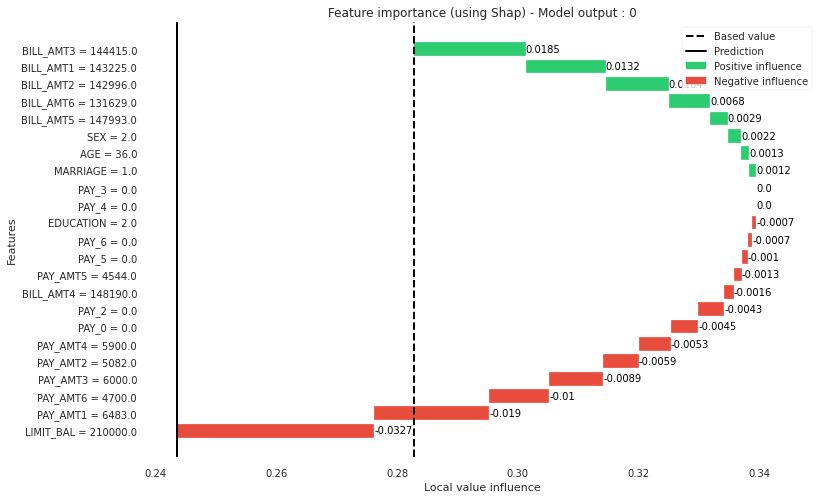

In [73]:
explainer_a.plot_local_explain(female_sample.iloc[0])
explainer_b.plot_local_explain(female_sample.iloc[0])